# Memoryviews and Cython

### memoryviews

Memoryviews, inspired by numpy and scipy, let you handle slices of arrays without expensively copying bytes.

Travis Oliphant, as quoted in Fluent:

>A memoryview is essentially a generalized NumPy array structure in Python itself (without the math). It allows you to share memory between data-structures (things like PIL images, SQLlite databases, NumPy arrays, etc.) without first copying. This is very important for large data sets.

In [1]:
import array
numbers = array.array('h', [-2, -1, 0, 1, 2])#short signed ints
type(numbers[0]), numbers.itemsize

(int, 2)

In [2]:
memv = memoryview(numbers)
memv_oct = memv.cast('B') # no copy
memv_oct

In [3]:
list(memv_oct)

[254, 255, 255, 255, 0, 0, 1, 0, 2, 0]

We can dive into a structure. Once we have read the data once from a file (get it at https://www.dropbox.com/s/e4rleswrcgwt3hp/pcanim.gif?dl=0 ), it does not need to be recopied just to inspect it. Here we use the `struct` module, which is useful to share data with C like systems.

In [4]:
import struct
fmt = '<3s3sHH'#little endian, 2 seq 3 bytes, 2 unsigned shorts
with open("pcanim.gif", 'rb') as fd:
    readit = fd.read()
    msg = memoryview(readit) #no copy
header = msg[:10] # 10 byte view, no copy, imagine the savings
bytes(header)# finally a copy

b'GIF89a\xe8\x03\x90\x01'

In [5]:
struct.unpack(fmt, header)#type/version/width/height

(b'GIF', b'89a', 1000, 400)

One can do this from bytes..

As we saw above, **memoryviews support indexing and slicing**. Multidimensional, even.

In [7]:
bs = b'Hello world'
print(type(bs))
memv = memoryview(bs)
memv[4], memv[2:4] #the second is a view

<class 'bytes'>


(111, <memory at 0x10394de88>)

In [10]:
memv.shape, memv.strides

((11,), (1,))

Or from numpy

In [8]:
import numpy as np
zerosmv = memoryview(np.zeros((10, 11, 12)))

In [56]:
zerosmv.shape, zerosmv.strides, zerosmv.ndim, zerosmv.itemsize #c cintigous, 

((10, 11, 12), (1056, 96, 8), 3, 8)

Look at the contiguity. Memoryviews, just like numpy arrays can be multi-dimensional, and come with some of the properties numpy arrays have...

### the buffer protocol

is how Python objects expose raw byte buffers (arrays)


In [11]:
type(msg), type(readit)

(memoryview, bytes)

In [12]:
readit[0]=5

TypeError: 'bytes' object does not support item assignment

In [13]:
msg[0]=5

TypeError: cannot modify read-only memory

`bytearray`s as opposed to `bytes`, are read-write, which leads to being able to pre-allocate a "buffer", get a memoryview on it, and use the slice syntax.

In [27]:
bytearray(readit)[0]=5

In [30]:
import os.path
with open("pcanim.gif", 'rb') as fd:
    data = bytearray(os.path.getsize("pcanim.gif"))
    fd.readinto(data)
mv = memoryview(data)
mv[0]=5

This gives us a way to do something we couldn't achieve by any other means - read from a file (or receive from a socket) directly into the middle of some existing buffer 

```python
buf = bytearray(...) # pre-allocated to the needed size
mv = memoryview(buf)
numread = f.readinto(mv[some_offset:])
```

Kurt Smith, in the O-Reilly cython book:

>The new buffer protocol is a C-level protocol. The new buffer protocol’s most important feature is its ability to represent the same underlying data in different ways. It allows NumPy arrays, several Python built-in types, and Cython-level array-like objects to share the same data without copying. With Cython, we can also easily extend the buffer protocol to work with data coming from an external library.

These are python types you can create a memoryview from:

- ndarray, py2 string, py3 unicode
- bytes and bytearray types, array.array, ctypes arrays
- third party, like in PIL


### Cython, numpy, and typed memoryviews

(in other words, how to use cython to write high performamce memory operations)

Cython has a c level type clled the **typed memoryview** which builds on the python memoryview type. As in python, its used to view and share data from a buffer...this C type builds on and supersets the functionality of the python memoryview. Since it works with the buffer protocol. it accepts any raw-byte buffer producing object.

you can also access `C` arrays using memview syntax with the typed memoryview.

Why is this kind of functionality interesting?

From https://jakevdp.github.io/blog/2014/05/05/introduction-to-the-python-buffer-protocol/ :

>Well, in scientific computing, most of the interesting algorithms are implemented in compiled code: for example, scipy is essentially a set of wrappers around NetLib utilities, which are well-tested implementations of scientific algorithms written mostly in Fortran and C. The ability for Python to natively share data with these compiled libraries is incredibly important for scientific computing. This is one big reason that NumPy and its predecessors were initially developed, and it's why the buffer protocol was later proposed and added to Python's standard library. The buffer protocol is extremely useful for what scientists do with Python: build intuitive interfaces to compiled legacy code.

In [14]:
%load_ext Cython

In [15]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x1066a8828>)

### Code using the cython buffer protocol

This example is from the python cookbook by Martelli et al

In [36]:
%%file clippy.pyx

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef clip(double[:] a, double minval, double maxval, double[:] out):
    if minval > maxval:
        raise ValueError("minval must be <= maxval") 
    for i in range(a.shape[0]):
        if a[i] < minval: 
            out[i] = minval
        elif a[i] > maxval: 
            out[i] = maxval
        else:
            out[i] = a[i]

Overwriting clippy.pyx


The typed parameters `a` and `out` declare those params as 1-d arrays of doubles; the sytax is fairly evocative on this point, Remember that `cpdef` makes `clip` both a c-level and a python level function, allowing it to be accessed from a different cython function.

`a` and `out` will access any array object that implements the memory view interface. Furthermore, as you might expect, no-copies will be made. Thus we could use an explicit memoryview constructor on a `bytearray` or a numpy `ndarray` or an `array.array`.

Notice we separate `out`. This is a convention and puts the responsibility of "allocating" `out` on the caller (who might use `np.empty_like/empty` or `np.zeros_like/zeros`.

`@cython.boundscheck(False)`:use if you know index won’t go out of range. `@cython.wraparound(False)` removes the usage of negative indices

In [16]:
import clippy

In [17]:
import numpy as np
b = np.random.uniform(-10,10,size=1000000)
c = np.zeros_like(b)

In [18]:
%timeit -n 5 clippy.clip(b, -5.0,5.0, c);

5 loops, best of 3: 6.74 ms per loop


In [19]:
%timeit -n 5 np.clip(b, -5.0,5.0, c);

5 loops, best of 3: 6.78 ms per loop


Wow, we are already competitive with numpy. 

Can we do better?

Lets see two separate ways of writing the conditional:

In [20]:
import dis
dis.dis("""
if a[i] < minval: 
    out[i] = minval
elif a[i] > maxval: 
    out[i] = maxval
else:
    out[i] = a[i]
"""
)

  2           0 LOAD_NAME                0 (a)
              3 LOAD_NAME                1 (i)
              6 BINARY_SUBSCR
              7 LOAD_NAME                2 (minval)
             10 COMPARE_OP               0 (<)
             13 POP_JUMP_IF_FALSE       29

  3          16 LOAD_NAME                2 (minval)
             19 LOAD_NAME                3 (out)
             22 LOAD_NAME                1 (i)
             25 STORE_SUBSCR
             26 JUMP_FORWARD            43 (to 72)

  4     >>   29 LOAD_NAME                0 (a)
             32 LOAD_NAME                1 (i)
             35 BINARY_SUBSCR
             36 LOAD_NAME                4 (maxval)
             39 COMPARE_OP               4 (>)
             42 POP_JUMP_IF_FALSE       58

  5          45 LOAD_NAME                4 (maxval)
             48 LOAD_NAME                3 (out)
             51 LOAD_NAME                1 (i)
             54 STORE_SUBSCR
             55 JUMP_FORWARD            14 (to 72)

  7     

In [21]:
import dis
dis.dis("""
out[i] = (a[i] if a[i] < maxval else maxval) if a[i] > minval else minval
"""
)

  2           0 LOAD_NAME                0 (a)
              3 LOAD_NAME                1 (i)
              6 BINARY_SUBSCR
              7 LOAD_NAME                2 (minval)
             10 COMPARE_OP               4 (>)
             13 POP_JUMP_IF_FALSE       48
             16 LOAD_NAME                0 (a)
             19 LOAD_NAME                1 (i)
             22 BINARY_SUBSCR
             23 LOAD_NAME                3 (maxval)
             26 COMPARE_OP               0 (<)
             29 POP_JUMP_IF_FALSE       42
             32 LOAD_NAME                0 (a)
             35 LOAD_NAME                1 (i)
             38 BINARY_SUBSCR
             39 JUMP_ABSOLUTE           51
        >>   42 LOAD_NAME                3 (maxval)
             45 JUMP_FORWARD             3 (to 51)
        >>   48 LOAD_NAME                2 (minval)
        >>   51 LOAD_NAME                4 (out)
             54 LOAD_NAME                1 (i)
             57 STORE_SUBSCR
             58 LOAD_

Ok lets use the second one: there is probably a correspondence between lines-of-bytecode and calls to python C-api that make conditional expressions fast

In [24]:
%%file clippy2.pyx

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef clip(double[:] a, double minval, double maxval, double[:] out):
    if minval > maxval:
        raise ValueError("minval must be <= maxval") 
    for i in range(a.shape[0]):
        out[i] = (a[i] if a[i] < maxval else maxval) if a[i] > minval else minval

Overwriting clippy2.pyx


In [25]:
import clippy2
%timeit -n 5 clippy2.clip(b, -5.0,5.0, c);

5 loops, best of 3: 3.85 ms per loop


Ok so we are now beating numpy out. Well, to be fair, the numpy one checks bounds, etc and handles multi-dimensional arrays properly.

We can use the `nogil` context manager to make sure that the c-compiled code gives up the GIL. We'll see next monday how this might help. Note that this is sharing CPU-bound code amongst threads! Its not going to do anything by itself but wont hurt us

In [26]:
%%file clippy3.pyx

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef clip(double[:] a, double minval, double maxval, double[:] out):
    if minval > maxval:
        raise ValueError("minval must be <= maxval") 
    with nogil:
        for i in range(a.shape[0]):
            out[i] = (a[i] if a[i] < maxval else maxval) if a[i] > minval else minval

Overwriting clippy3.pyx


In [27]:
import clippy3
%timeit -n 5 clippy3.clip(b, -5.0,5.0, c);

5 loops, best of 3: 3.18 ms per loop


As a final example in the clippy series, let us implement it in C. This is what we would do in dealing with "legacy" C libraries..

In [28]:
%%file _clippy4.h
void _clip(double *a, int n, double min, double max, double *out);

Overwriting _clippy4.h


In [29]:
%%file _clippy4.c
void _clip(double *a, int n, double min, double max, double *out) { 
    double x;
    for (; n >= 0; n--, a++, out++) {
        x=*a;
        *out=x>max?max:(x<min?min:x); 
    }
}

Overwriting _clippy4.c


#### Proper, file-based build...

Two things happen below: first a cast. In cython, something like:

`cdef int *ptr_i = <int*>v` becomes `int *ptr_i = (int*)v;` in C.

Notice how `double *a` becomes `<double*> &a[0]`.

Cython does not support the star syntax for C pointers, since this is the syntax for positional arguments. Instead gets what at location 0. The ampersand adress getting works.

In [30]:
%%file clippy4.pyx

cdef extern from "_clippy4.h": 
    void _clip(double *a, int n, double min, double max, double *out) 
    
cpdef clip(double[:] a, double minval, double maxval, double[:] out):
    return _clip(<double*> &a[0], a.shape[0], minval, maxval, <double *> &out[0])


Overwriting clippy4.pyx


In [31]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension 
from Cython.Distutils import build_ext
ext_modules = [
    Extension('clippy4',
              sources=['clippy4.pyx', '_clippy4.c'],
              include_dirs = ['.'])]
setup(
  name = 'Clippy',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules
)

Overwriting setup.py


In [32]:
!python setup.py build_ext --inplace

running build_ext
cythoning clippy4.pyx to clippy4.c
building 'clippy4' extension
gcc -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I//anaconda/envs/py35/include -arch x86_64 -I. -I//anaconda/envs/py35/include/python3.5m -c clippy4.c -o build/temp.macosx-10.5-x86_64-3.5/clippy4.o
clippy4.c:1832:134: warning: code will never be executed [-Wunreachable-code]
  ...__Pyx_INCREF(__pyx_t_3); __pyx_t_1++; if (unlikely(0 < 0)) {__pyx_filename = __pyx_f[1]; __py...
                                                                                  ^~~~~~~
clippy4.c:3809:138: warning: code will never be executed [-Wunreachable-code]
  ...__Pyx_INCREF(__pyx_t_5); __pyx_t_3++; if (unlikely(0 < 0)) {__pyx_filename = __pyx_f[1]; __py...
                                                                                  ^~~~~~~
clippy4.c:3801:137: warning: code will never be executed [-Wunreachable-code]
  ...__Pyx_INCREF(__pyx_t_5); __pyx_t_3++

In [33]:
import clippy4

In [34]:
%timeit -n 5 clippy4.clip(b, -5.0,5.0, c);

5 loops, best of 3: 3.71 ms per loop


In [35]:
clippy4.clip(b, -5.0,5.0, c)

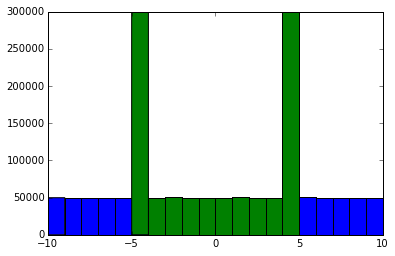

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(b, bins=20)
plt.hist(c, bins=10);

### More meoryviews in Cython: calculating distances.

This example was adapted from http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2/ where you can read about Numba as well.

The problem is you have Xn vectors of dimension m, of which we will take Vn of them to be vantage points, with respect to whom we will calculate distances. This idea will come useful in indexing time-series similarity, as we shall see soon.

This below is the pure python implementation:

In [39]:
# X is Xn x m, V is Vn x m
def distance_python(X, V):
    Xn = X.shape[0]
    Vn = V.shape[0]
    m = X.shape[1]
    D = np.empty((Xn, Vn), dtype=np.float)
    for i in range(Xn):
        for j in range(Vn):
            d = 0.0
            for k in range(m):
                tmp = X[i, k] - V[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

we create the vectors and randomly choose vantage-points from them

In [40]:
choices = np.random.choice(range(1000), 40, replace=False)

In [41]:
mask=np.array([i in choices for i in np.arange(1000)])

In [42]:
ts = np.random.random((1000, 100))
v = ts[mask,:]

In [43]:
v.shape, ts.shape

((40, 100), (1000, 100))

In [81]:
v.strides

(800, 8)

In [44]:
%timeit -r 1 -n 5 distance_python(ts, v);

5 loops, best of 1: 2.51 s per loop


`numpy` is wicked efficient for many things. Looksie below, but broadcasting creates a lot of temporaries, which hurt memory usage and thus performance (caches need to be filled emptied filled emptied...)

In [49]:
# but much larger memory usage
def distance_numpy_broadcast(X, V):
    return np.sqrt(((X[:, None, :] - V) ** 2).sum(-1))


In [50]:
%timeit  -n 5 distance_numpy_broadcast(ts,v);

5 loops, best of 3: 27.6 ms per loop


Lets do this in cython.

Notice the `libc` import below. This is because they created pxd files for a whole bunch of standard libraries. See here:
https://github.com/cython/cython/tree/master/Cython/Includes

In [51]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt
import numpy
cimport numpy
@cython.boundscheck(False)
@cython.wraparound(False)
def distance_cython(double[:, ::1] X, double[:, ::1] V):
    cdef int Xn = X.shape[0]
    cdef int Vn = V.shape[0]
    cdef int m = X.shape[1]
    cdef double temp, d
    cdef int i,j
    cdef double[:, ::1] D = numpy.empty((Xn, Vn), dtype=numpy.float64)
    for i in range(Xn):
        for j in range(Vn):
            d = 0.0
            for k in range(m):
                temp = X[i, k] - V[j, k]
                d += temp * temp
            D[i, j] = sqrt(d)
    return numpy.asarray(D)


In [52]:
%timeit  -n 5 distance_cython(ts,v);

5 loops, best of 3: 4.35 ms per loop


In [53]:
distance_cython(ts,v)

array([[ 4.6523988 ,  4.44551301,  4.3890002 , ...,  4.00755775,
         4.22322105,  4.37393519],
       [ 4.12253652,  4.21170361,  3.90994741, ...,  3.88914647,
         4.35965492,  3.93944817],
       [ 4.17936983,  3.88236682,  3.90837503, ...,  3.71925729,
         4.30428292,  4.13293549],
       ..., 
       [ 4.15150826,  4.14266396,  3.91508068, ...,  4.14206795,
         4.0111654 ,  4.16435447],
       [ 4.21976561,  4.38257488,  3.95682653, ...,  3.8568077 ,
         4.16376601,  4.10713131],
       [ 4.12525003,  3.80021152,  4.23650781, ...,  4.39965402,
         3.99301888,  3.93165919]])

### Refactoring: Using pointers to the memoryviews

In [54]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
#cdef double distance_vector_c(double[:] V1, double[:] V2, int dalen):
cdef double distance_vector_c(double* V1, double* V2, int dalen):
    cdef double temp, d
    d = 0.0
    for k in range(dalen):
        temp = V1[k] - V2[k]
        d += temp * temp
    return sqrt(d)

#def distance_cython(double[:, ::1] X, double[:, ::1] V):

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef distance_cython_2(double[:, ::1] X, double[:, ::1] V):
    cdef int Xn = X.shape[0]
    cdef int Vn = V.shape[0]
    cdef int m = X.shape[1]
    cdef double temp, d
    cdef int i,j
    cdef double[:, ::1] D = np.empty((Xn, Vn), dtype=np.float64)
    for i in range(Xn):
        for j in range(Vn):
            d = distance_vector_c(&X[i,0], &V[j,0], m)
            D[i, j] = sqrt(d)
    return np.asarray(D)


In [55]:
%timeit  -n 5 distance_cython_2(ts,v);

5 loops, best of 3: 4.74 ms per loop


You could have done this by taking 1-d memory views in the upper function and appropriate slices. But that has a cost in terms of going back-and-forth into python, because the memoryview must be queried to do the slicing.

In [58]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
#cdef double distance_vector_c(double[:] V1, double[:] V2, int dalen):
cdef double distance_vector_mv(double[:] V1, double[:] V2, int dalen):
    cdef double temp, d
    d = 0.0
    for k in range(dalen):
        temp = V1[k] - V2[k]
        d += temp * temp
    return sqrt(d)

#def distance_cython(double[:, ::1] X, double[:, ::1] V):

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef distance_cython_mv(double[:, ::1] X, double[:, ::1] V):
    cdef int Xn = X.shape[0]
    cdef int Vn = V.shape[0]
    cdef int m = X.shape[1]
    cdef double temp, d
    cdef int i,j
    cdef double[:, ::1] D = np.empty((Xn, Vn), dtype=np.float64)
    for i in range(Xn):
        for j in range(Vn):
            d = distance_vector_mv(X[i,:], V[j,:], m)
            D[i, j] = sqrt(d)
    return np.asarray(D)


In [59]:
%timeit  -n 5 distance_cython_mv(ts,v);

5 loops, best of 3: 5.5 ms per loop


### Refactoring: Directly using numpy as a type

(this is where the cimport comes in useful)

In [145]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double distance_vector_c(double* V1, double* V2, int dalen):
    cdef double temp, d
    d = 0.0
    for k in range(dalen):
        temp = V1[k] - V2[k]
        d += temp * temp
    return sqrt(d)

#def distance_cython(double[:, ::1] X, double[:, ::1] V):

#none does not raise a typeerror

@cython.boundscheck(False)
@cython.wraparound(False)
def distance_cython_3(np.ndarray[double, ndim=2, mode="c"] X not None, np.ndarray[double, ndim=2, mode="c"] V not None):
    cdef int Xn = X.shape[0]
    cdef int Vn = V.shape[0]
    cdef int m = X.shape[1]
    cdef double temp, d
    cdef int i,j
    cdef double[:, ::1] D = np.empty((Xn, Vn), dtype=np.float64)
    for i in range(Xn):
        for j in range(Vn):
            d = distance_vector_c(&X[i,0], &V[j,0], m)
            D[i, j] = sqrt(d)
    return np.asarray(D)


In [147]:
%timeit  -n 5 distance_cython_3(ts,v);

5 loops, best of 3: 4.43 ms per loop


In [146]:
distance_cython_3(ts,v)

array([[ 2.08694069,  2.04722032,  2.05245143, ...,  2.05322871,
         2.04161444,  2.05647051],
       [ 2.06093671,  2.04073185,  1.99626023, ...,  1.96875489,
         1.99419393,  1.95320067],
       [ 2.01694542,  1.98781607,  2.0262516 , ...,  1.9761725 ,
         1.96756931,  2.03667205],
       ..., 
       [ 2.03245895,  2.09468797,  2.0204086 , ...,  1.99362   ,
         1.98224084,  2.00844978],
       [ 2.0479603 ,  2.03884266,  1.94662744, ...,  2.08367386,
         2.04550359,  2.03951437],
       [ 2.10742207,  2.03434757,  2.09783645, ...,  2.07412569,
         2.02567837,  2.03844292]])

### Extension Types

In python, everythng has an object, and has attributes, likely in `__dict__` or `__slots__`, and has methods. 

Cython allows C level access to this data.

This is already true for the built in types, but we can do this by creating **extension types**. These have fast access to methods and data. You can do this in pure C, but python makes this simple.

Its critical that attributes are declared with `cdef`, so that the underlying structure can be allocated FIRST (in `__cinit__`), before the `__init__` constructor is called. (see below for an example of memory allocation in this process).

Three types of attributes:

- private by default
- `readonly` so that they cant be changed: like a property with get but no set
- `public`

Here we create a Vector class as an illustration. Notice the implementation of `_add__` is a bit different: there is no `__radd__` in extension classes, so we must handle all the situations ourselves. Notice we reuse a 1-D distance implementation.

In [194]:
%%cython --annotate
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double distance_vector_c(double[:] V1, double[:] V2, int dalen):
    cdef double temp, d
    d = 0.0
    for k in range(dalen):
        temp = V1[k] - V2[k]
        d += temp * temp
    return sqrt(d)

cdef class Vector:
    cdef public double[:] data
    cdef readonly int dim
    
    def __init__(self, double[:] data):
        self.data = np.asarray(data)
        self.dim = self.data.shape[0]
        
    def __repr__(self):
        return "Vector({}...)".format(list(self.data[:4]))
    
    def __add__(x, y):
        if isinstance(x, Vector):
            if isinstance(y, int):
                return Vector(np.asarray(x.data) + y)
            elif isinstance(y, Vector):
                return Vector(np.asarray(x.data) + np.asarray(y.data))
            elif isinstance(y, memoryview):
                return Vector(np.asarray(x.data) + np.asarray(y))
            else:
                return NotImplemented
        elif isinstance(y, Vector):
            if isinstance(x, int):
                return Vector(np.asarray(y.data) + x)
            elif isinstance(x, Vector):
                return Vector(x.data + y.data)
            elif isinstance(x, memoryview):
                return Vector(y.data + np.asarray(x))
            else:
                return NotImplemented
        else:
            return NotImplemented
        
def vecdistance(Vector v1, Vector v2):
    return distance_vector_c(v1.data, v2.data, v1.dim)

In [189]:
v1 = Vector(np.ones(3))
v2 = Vector(np.random.random(3))
v1,v2

(Vector([1.0, 1.0, 1.0]...),
 Vector([0.3703754041102988, 0.14599847824892176, 0.5916532076092261]...))

In [190]:
v1.data[0], v2.data[0]

(1.0, 0.3703754041102988)

In [191]:
v1+v2

Vector([1.3703754041102987, 1.1459984782489219, 1.5916532076092262]...)

In [192]:
v1 + 1, 1 + v2

(Vector([2.0, 2.0, 2.0]...),
 Vector([1.3703754041102987, 1.1459984782489219, 1.5916532076092262]...))

In [193]:
vecdistance(v1,v2)

1.1368785483763253

### Points: extension classes

we had this in the last lecture. It shows how one might create an extension class from a structure. It also surves as an example of incorporating a C library. Pay special attention to how properties are declared: remember that all members are private by default.

In [271]:
%%file pointy.h

typedef struct Point {
    double x;
    double y;
} Point;

double distance(Point *p1, Point *p2);

Overwriting pointy.h


In [277]:
%%file pointy.c
#include <math.h>
#include "pointy.h"

double distance(Point *p1, Point *p2) { 
    return hypot(p1->x - p2->x, p1->y - p2->y);
}


Overwriting pointy.c


In [278]:
%%file cpointy.pxd

cdef extern from "pointy.h":
    ctypedef struct Point:
                 double x
                 double y
    double distance(Point *, Point *)


Overwriting cpointy.pxd


Notice memory allocation and deallocation. You dont want to do this in the constructor, as alterbnative constructors may be called.

In [289]:
%%file pointclass.pyx
cimport cpointy
from libc.stdlib cimport malloc, free

cdef class Point:
    
    cdef cpointy.Point *_c_point
    
    def __cinit__(self, double x, double y):
            self._c_point = <cpointy.Point *> malloc(sizeof(cpointy.Point))
            if self.c_point == NULL:
                raise MemoryError()
            self._c_point.x = x
            self._c_point.y = y
            
    def __dealloc__(self):
        if self._c_point != NULL:
            free(self._c_point)

    property x:
        def __get__(self):
            return self._c_point.x 
        def __set__(self, value):
            self._c_point.x = value
            
    property y:
        def __get__(self):
            return self._c_point.y 
        def __set__(self, value):
            self._c_point.y = value

def distance(Point p1, Point p2):
    return cpointy.distance(p1._c_point, p2._c_point)

Overwriting pointclass.pyx


In [290]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension 
from Cython.Distutils import build_ext
ext_modules = [
    Extension('pointclass',
              sources=['pointclass.pyx', 'pointy.c'],
              include_dirs = ['.'])]
setup(
  name = 'pointclass',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules
)

Overwriting setup.py


In [291]:
!python setup.py build_ext --inplace

running build_ext
cythoning pointclass.pyx to pointclass.c
building 'pointclass' extension
gcc -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I//anaconda/envs/py35/include -arch x86_64 -I. -I//anaconda/envs/py35/include/python3.5m -c pointclass.c -o build/temp.macosx-10.5-x86_64-3.5/pointclass.o
pointclass.c:2523:28: warning: unused function '__Pyx_PyObject_AsString' [-Wunused-function]
static CYTHON_INLINE char* __Pyx_PyObject_AsString(PyObject* o) {
                           ^
pointclass.c:2520:32: warning: unused function '__Pyx_PyUnicode_FromString' [-Wunused-function]
static CYTHON_INLINE PyObject* __Pyx_PyUnicode_FromString(const char* c_str) {
                               ^
pointclass.c:2585:26: warning: unused function '__Pyx_PyObject_IsTrue' [-Wunused-function]
static CYTHON_INLINE int __Pyx_PyObject_IsTrue(PyObject* x) {
                         ^
pointclass.c:2635:33: warning: unused function '__Pyx_PyIndex_AsSsiz

In [292]:
import pointclass as pc

In [293]:
p1 = pc.Point(2,3)
p2 = pc.Point(4,5)
p1,p2

(<pointclass.Point at 0x10d274f30>, <pointclass.Point at 0x10d274f48>)

In [294]:
print(p1.x)
print(p2.y)
pc.distance(p1,p2)

2.0
5.0


2.8284271247461903

In [295]:
del p1

### GIL and parallelism

From the Cython book:
>“a mutex that prevents multiple native threads from executing Python bytecodes at once.” In other words, the GIL ensures that only one native (or OS-level) thread executes Python bytecodes at any given time during the execution of a CPython program. The GIL affects not just Python-level code, but the Python/C API as a whole.
Why is it in place? “This lock is necessary mainly because CPython’s memory manage‐ ment is not thread-safe. (However, since the GIL exists, other features have grown to depend on the guarantees that it enforces.)”

>- The GIL is necessary to help with the memory management of Python objects.
- C code that does not work with Python objects can be run without the GIL in effect, allowing fully threaded execution.

In cython we can declare external functions to be nogil, after making sure they are threadsafe

```python
cdef extern from "math.h": 
    double sin(double x) nogil 
    double cos(double x) nogil
```

and whenever an external library does not interact with python objects at all, we can do the same thing. Indeed we could write:

```
cdef extern from "math.h" nogil: 
    double sin(double x)
    ...
```

The lab will have an example of how this is used using `openmp`. You could roll your own after creating a threadpool.